In [ ]:
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import cv2## image processing
import os## operating system
import random
import copy
from google.colab import files
import torch, torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
! pip install -q kaggle

In [ ]:
files.upload()

NameError: ignored

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 663M/675M [00:05<00:00, 114MB/s] 
100% 675M/675M [00:05<00:00, 132MB/s]


In [ ]:
!unzip /content/cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [ ]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('cell_images/Parasitized')
train_paths_parasitized = ['cell_images/Parasitized/' + i for i in train_paths_parasitized]

train_paths_uninfected += os.listdir('cell_images/Uninfected')
train_paths_uninfected = ['cell_images/Uninfected/' + i for i in train_paths_uninfected]

paths = train_paths_parasitized + train_paths_uninfected

paths.remove("cell_images/Parasitized/Thumbs.db")
paths.remove("cell_images/Uninfected/Thumbs.db")

random.shuffle(paths)

FRACTION = 0.8
train_paths = paths[0:int(FRACTION*len(paths))]
val_paths = paths[int(FRACTION*len(paths)):]
print(len(val_paths), len(train_paths))

5512 22046


In [ ]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])
    
    if(self.image_filepaths[index].split('/')[1] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0

    
    if self.transform:
      image = self.transform(image = image)['image']
    
    return image, label


In [ ]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3),
                        
                        A.RandomRotate90(),   
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),
                        A.Normalize(),
                       
                        
])

In [ ]:
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [ ]:
image, label = next(iter(train_loader))
print(image[2][100:150,100:150,0])

tensor([[0.5536, 0.5364, 0.5364,  ..., 0.5707, 0.5707, 0.5536],
        [0.5707, 0.5536, 0.5536,  ..., 0.5536, 0.5707, 0.5707],
        [0.5536, 0.5536, 0.5707,  ..., 0.5707, 0.5707, 0.5707],
        ...,
        [0.4508, 0.3652, 0.2624,  ..., 0.6049, 0.6221, 0.6221],
        [0.4337, 0.3309, 0.2282,  ..., 0.6221, 0.6221, 0.6392],
        [0.3994, 0.3138, 0.2282,  ..., 0.6221, 0.6221, 0.6221]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., dtype=torch.float64)


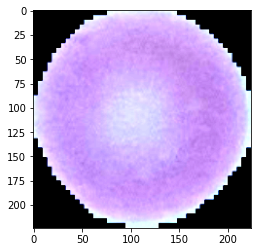

In [ ]:
plt.imshow(image[0])
print(label[0])

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super(LeNet, self).__init__()
      
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
      self.bn1 = nn.BatchNorm2d(6)
      self.pool1 = nn.MaxPool2d(2,2)
      self.dropout1 = nn.Dropout2d(0.2)

      self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.bn2 = nn.BatchNorm2d(16)
      self.pool2 = nn.MaxPool2d(2,2)

      self.fc3 = nn.Linear(50176, 100)
      self.bn3 = nn.BatchNorm1d(100)
      
      self.fc4 = nn.Linear(100, 10)
      self.bn4 = nn.BatchNorm1d(10)
      
      self.fc5 = nn.Linear(10, 1)
        
    def forward(self, input):

      output = self.dropout1(self.pool1(self.bn1(F.relu(self.conv1(input)))))
      output = self.pool2(self.bn2(F.relu(self.conv2(output))))
      
      output = output.reshape(-1, 16*56*56)
      output = self.bn3(F.relu(self.fc3(output)))
      output = self.bn4(F.relu(self.fc4(output)))

      output = torch.sigmoid(self.fc5(output))
        
      return output


model = LeNet()

model(torch.zeros((3,3,224,224)))                   

tensor([[0.4654],
        [0.4730],
        [0.4654]], grad_fn=<SigmoidBackward0>)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3, )

In [ ]:
print(device)

cuda:0


In [ ]:
def round(x):
  if(x>= 0.5):
    return 1.
  else:
    return 0.

In [ ]:
def get_accuracy(epoch):
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0 
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1

  print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch, 100*epoch_accuracy/len(val_dataset)))


In [ ]:
def train(EPOCHS):

  model.to(device)
  
  for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for i, (image, label) in enumerate(train_loader):

      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)
      
      label = torch.unsqueeze(label, -1)
      label = label.float()
      label = label.to(device)

      optimizer.zero_grad()

      output = model(image)

      loss = loss_fn(output, label)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      
      step_length = int(len(train_loader)/2)

      if(i%step_length) == 0:
              print('Epoch Number: {}, step: [{}|{}] ----> Loss: {}' .format(epoch+1, i, len(train_loader), loss.item()))
    print("Loss for epoch Number {} is :{}".format(epoch+1, epoch_loss/len(train_loader)))
    
    get_accuracy(epoch)


In [ ]:
train(20)

Epoch Number: 1, step: [0|689] ----> Loss: 0.7978537678718567
Epoch Number: 1, step: [344|689] ----> Loss: 0.443876177072525
Epoch Number: 1, step: [688|689] ----> Loss: 0.44570982456207275
Loss for epoch Number 1 is :0.5038634987199254
The Validation Accuracy for this epoch:0 is:92.48911465892598 
Epoch Number: 2, step: [0|689] ----> Loss: 0.2583308219909668
Epoch Number: 2, step: [344|689] ----> Loss: 0.2292211651802063
Epoch Number: 2, step: [688|689] ----> Loss: 0.23481419682502747
Loss for epoch Number 2 is :0.2619059797111461
The Validation Accuracy for this epoch:1 is:91.76342525399129 
Epoch Number: 3, step: [0|689] ----> Loss: 0.050250470638275146
Epoch Number: 3, step: [344|689] ----> Loss: 0.20530696213245392
Epoch Number: 3, step: [688|689] ----> Loss: 0.06257139891386032
Loss for epoch Number 3 is :0.19573745847894594
The Validation Accuracy for this epoch:2 is:93.86792452830188 
Epoch Number: 4, step: [0|689] ----> Loss: 0.18901333212852478
Epoch Number: 4, step: [344|689